<a href="https://www.kaggle.com/alperenkaran/why-you-shouldn-t-train-test-split-small-datasets?scriptVersionId=88893634" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

In this notebook, I am going to explain why it is a bad idea to train-test split a small dataset.

# Read the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('../input/iris/Iris.csv')
data.sample(3)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
25,26,5.0,3.0,1.6,0.2,Iris-setosa
30,31,4.8,3.1,1.6,0.2,Iris-setosa
122,123,7.7,2.8,6.7,2.0,Iris-virginica


The `Id` column is useless, we delete it.

The `Species` contains the labels for the machine learning task. 

In [3]:
x = data.drop(['Id','Species'], axis=1) #the features are in x
y = data['Species'] #the labels are in y

In [4]:
print('The data has', len(data), 'rows.')

The data has 150 rows.


# Let's draw a scatterplot

The dataset have originally four features: `SepalLengthCm`, `SepalWidthCm`, `PetalLengthCm`, and `PetalWidthCm`.

Let's plot `SepalWidthCm` against `PetalWidthCm`.

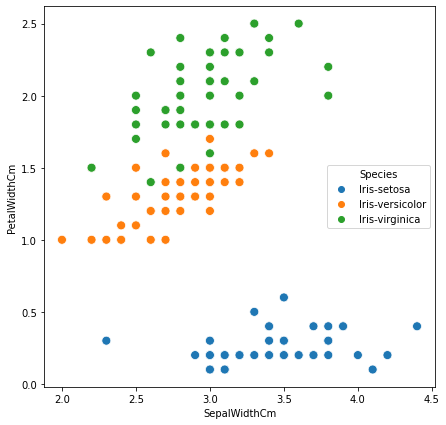

In [5]:
plt.figure(figsize=(7,7))
sns.scatterplot(x=x['SepalWidthCm'], y=x['PetalWidthCm'], hue=y, s=80)
plt.show()

It is clear that the blue points are very easy to classify, and the errors (if any) are expected to occur between the orange and green points.

In particular, if we only used these two features (Sepal width and Petal width), the misclassification errors would appear at the points highlighted in thick black boundary below.

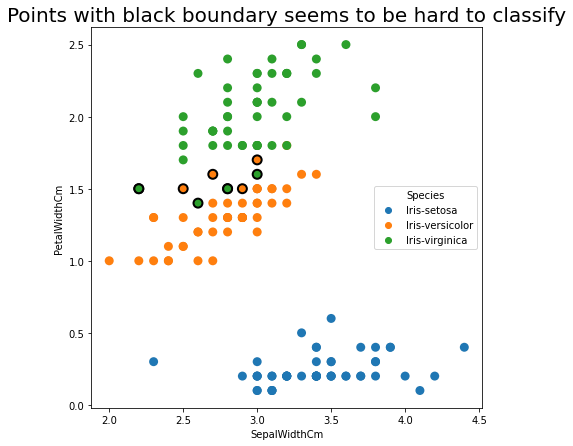

In [6]:
difficult_points = [54,68,72,77,78,83,119,129,133,134]
line_widths = [2 if i in difficult_points else .01 for i in range(150)]

plt.figure(figsize=(7,7))
sns.scatterplot(x=x['SepalWidthCm'], y=x['PetalWidthCm'], hue=y, s=80, edgecolor='black', linewidth=line_widths)
plt.title('Points with black boundary seems to be hard to classify', fontsize=20)
plt.show()

# What happens if you do a train-test split?

- If you use 20% of your data for testing, then actually you are sparing 150*0.20 = 30 data points for test. This means that, every misclassification will cost you 3.33% accuracy.
- If you are lucky enough, then your test set would not contain any of the highlighted (black boundary) points above, and you would get 100% accuracy.

# Try with a bunch of different train-test splits

We will control the randomness of the split via the `random_state` argument in the `train_test_split` function below.

We create a pipeline where the input is standardized first, then fed into the svm classifier.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

accuracies = []

for i in range(500):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=i) #we control the random_state parameter
    pipeline = make_pipeline(StandardScaler(), SVC(random_state=0)) #first we scale, then run our classifier
    pipeline.fit(x_train, y_train)
    accuracy = pipeline.score(x_test, y_test)
    accuracies.append(accuracy)

In [8]:
freq_table = pd.Series(accuracies).value_counts().sort_index().reset_index()
freq_table.columns = ['accuracy','frequency']
freq_table

,accuracy,frequency
0,0.866667,11
1,0.900000,38
2,0.933333,124
3,0.966667,189
4,1.000000,138


So, it appears that
- The accuracies indeed change by 3.33%
- The accuracy on the test set highly depends on the random state

__Question:__ Why doesn't this happen in large datasets?

__Answer:__ It does. But since the test set in large datasets is also large, the effect of the random state is negligible.

# Demonstration

In [9]:
# random_state = 0

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=0)
pipeline = make_pipeline(StandardScaler(), SVC(random_state=0)) #first we scale, then run our classifier
pipeline.fit(x_train, y_train)
accuracy = pipeline.score(x_test, y_test)

print('Accuracy for random_state=0 is',str(accuracy*100) +'%')

Accuracy for random_state=0 is 100.0%


In [10]:
# random_state = 7

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=7)
pipeline = make_pipeline(StandardScaler(), SVC(random_state=0)) #first we scale, then run our classifier
pipeline.fit(x_train, y_train)
accuracy = pipeline.score(x_test, y_test)

print('Accuracy for random_state=7 is',str(np.round(accuracy*100,2))+'%')

Accuracy for random_state=7 is 86.67%


# What should we do?

We should report the cross validation results. Furthermore, we should create as many folds as possible. For this, we are going to use `LeaveOneOut` cross validation. 

That is, the test set will consist of only one row, and row will be used as a test set once and only once.

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
pipeline = make_pipeline(StandardScaler(), SVC(random_state=0))

cv_result = cross_val_score(pipeline, x, y, cv=loo)
print('Leave-One-Out cross validation accuracy is', str(np.round(100*np.mean(cv_result),2))+'%')

Leave-One-Out cross validation accuracy is 96.67%


In [12]:
print('Difficult points: (from the figure above)', difficult_points)
print('Misclassifications:',np.where(cv_result==0)[0].tolist())

Difficult points: (from the figure above) [54, 68, 72, 77, 78, 83, 119, 129, 133, 134]
Misclassifications: [77, 83, 106, 119, 133]


It appears that our misclassification errors appeared where we have guessed!